<a href="https://colab.research.google.com/github/PWhiddy/jax-experiments/blob/main/ImageRep3GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install einops pynvml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
import torchvision
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
from einops import rearrange
import matplotlib.pyplot as plt
import time
import nullcontext
from tqdm.notebook import trange, tqdm

In [20]:
device = "cuda" # "cpu"
ctx = nullcontext() if device == 'cpu' else torch.amp.autocast(device_type=device, dtype=torch.float16)

In [4]:
class ImgNN(nn.Module):

  def __init__(self, hidden_size, layer_count, freqs=10):
      super().__init__()
      self.freqs = freqs
      self.in_proj = nn.Linear(freqs * 2, hidden_size) # nn.Linear(2, hidden_size)#
      self.out_proj = nn.Linear(hidden_size, 3)
      self.layers = [self.in_proj]
      for _ in range(layer_count):
        self.layers.append(nn.Linear(hidden_size, hidden_size))
        self.layers.append(nn.ReLU())
      self.layers.append(self.out_proj)
      self.layers = nn.Sequential( *self.layers )
  
  def to_freq(self, coords):
    return torch.hstack([
      torch.outer(coords[:, 0], 2 ** torch.arange(self.freqs, device=device)).sin(),
      torch.outer(coords[:, 1], 2 ** torch.arange(self.freqs, device=device)).sin()
    ])

  def forward(self, coords):
      return self.layers(self.to_freq(coords))
      #return self.layers(0.005*coords)

In [5]:
img = torchvision.io.read_image("horse.jpeg") #torchvision.transforms.Resize((500,1000))(torchvision.io.read_image("horse.jpeg"))

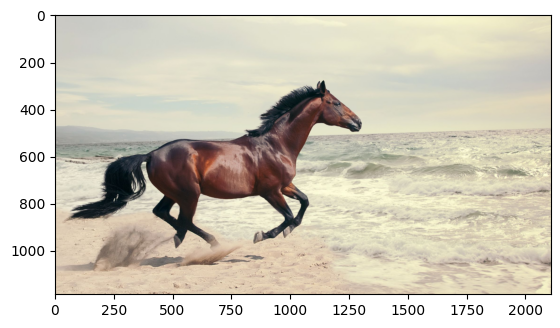

In [6]:
plt.imshow(img.permute(1, 2, 0))

In [7]:
img.shape

torch.Size([3, 1186, 2109])

In [9]:
def make_img_coords(width, height):
  X, Y = np.mgrid[0:width, 0:height]
  return np.dstack([Y.ravel() / height, X.ravel() / height])[0]

In [11]:
input_coords = torch.tensor(make_img_coords(img.shape[1], img.shape[2]), dtype=torch.float).to(device)
input_pixels = rearrange(img / 255.0, "c h w -> (h w) c").to(device)

In [21]:
def render(nn):
  with torch.no_grad(), ctx:
    result_pixs = nn( 
        torch.tensor(make_img_coords(img.shape[1], img.shape[2]), dtype=torch.float).to(device) 
        ).detach()
    img_pix = result_pixs.reshape(img.shape[1], img.shape[2], 3)
    return img_pix
    #plt.imshow(img_pix)

In [22]:
imgNN = ImgNN(256, 3).to(device)
#opt = torch.optim.SGD(imgNN.parameters(), lr=0.5, momentum=0.9)
opt = torch.optim.Adam(imgNN.parameters(), lr=0.001)
batch_size = 8*2048
sub_batches = 300
pbar = trange(10)
for epoch in pbar:
    iters = 0
    r = render(imgNN)
    torchvision.utils.save_image(r.permute(2, 0, 1).float().cpu(), f"r_{epoch:03d}.jpg")
    for idx in range(sub_batches):
        t0 = time.time()
        pix_indices = torch.randint(input_pixels.shape[0], (batch_size,), device=device)
        xb = input_coords[pix_indices]
        yb = input_pixels[pix_indices]
        with ctx:
          pred = imgNN(xb)
        #print(pred.shape)
        #print(yb.shape)
        loss = ((pred - yb) ** 2).mean()

        loss.backward()
        #print(loss.item())
        opt.step()
        opt.zero_grad()
        dt = time.time() - t0
        pbar.set_description(f"Loss: {loss.item():.4f} pixels/second: {batch_size / dt:0.0f} epoch: {epoch} iter: {iters} gpu utilization: {torch.cuda.utilization(device):02d}% progress")
        iters += 1
    
    #print(loss.item())

  0%|          | 0/10 [00:00<?, ?it/s]

In [23]:
r = render(imgNN)

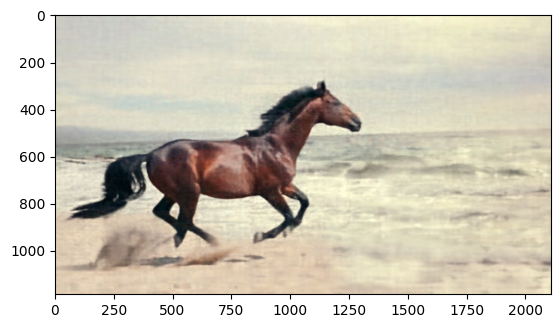

In [26]:
plt.imshow(r.float().cpu())